Found 19900 images belonging to 2 classes.
Found 6451 images belonging to 2 classes.
Found 6774 images belonging to 2 classes.
Epoch 1/5
621/621 - 16950s - loss: 0.3111 - accuracy: 0.9803 - precision: 0.0426 - recall: 0.0057 - auc: 0.7344 - val_loss: 0.2947 - val_accuracy: 0.9840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7361 - 16950s/epoch - 27s/step
Epoch 2/5
621/621 - 4043s - loss: 0.2799 - accuracy: 0.9825 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7852 - val_loss: 0.6617 - val_accuracy: 0.9840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6415 - 4043s/epoch - 7s/step
Epoch 3/5
621/621 - 4038s - loss: 0.2597 - accuracy: 0.9825 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7678 - val_loss: 0.2519 - val_accuracy: 0.9841 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7487 - 4038s/epoch - 7s/step
Epoch 4/5
621/621 - 4040s - loss: 0.2342 - accuracy: 0.9825 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc

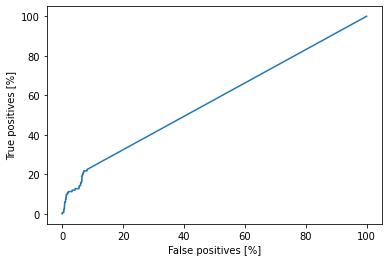

202/202 - 941s - loss: 40.9901 - accuracy: 0.9840 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5584 - 941s/epoch - 5s/step
212/212 - 986s - loss: 40.3535 - accuracy: 0.9804 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5435 - 986s/epoch - 5s/step
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


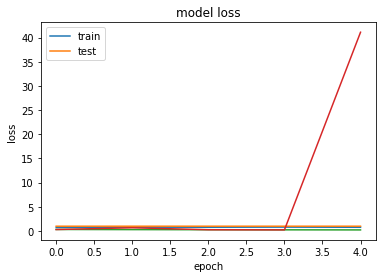

In [2]:
import os
from PIL import Image


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import math
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_examples = 19900
test_examples = 6774
validation_examples = 6451

img_height = img_width = 224
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    dtype=None,
)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=None)
test_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=None)
train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/data/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=42,
)
validation_gen = validation_datagen.flow_from_directory(
    "/content/drive/MyDrive/data/validation",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=42,
)

test_gen = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/data/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=42,
)

METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",
                   trainable=True),  # Can be True, see below.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=METRICS,
)

history = model.fit(
    train_gen,
    epochs=5,
    verbose=2,
    steps_per_epoch=train_examples // batch_size,
    validation_data=validation_gen,
    validation_steps=validation_examples // batch_size,
    )
def plot_roc(labels, data):
    predictions = model.predict(data)
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp)
    plt.xlabel("False positives [%]")
    plt.ylabel("True positives [%]")
    plt.show()

test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels, y)
    num_batches += 1
    if num_batches == math.ceil(test_examples / batch_size):
        break

plot_roc(test_labels, test_gen)
model.evaluate(validation_gen, verbose=2)
model.evaluate(test_gen, verbose=2)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('auc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
